In [43]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn
import os
from scipy import sparse

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

scanpy==1.3.2 anndata==0.6.11 numpy==1.14.6 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In this notebook, we'll apply BBKNN to four pancreas datasets generated with different technologies. We'll also take a look at how trimming and data scaling impact the results. The bulk of the analysis will be based on the [Seurat-like](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb) scanpy tutorial, with BBKNN slotting into the `sc.pp.neighbors()` spot. We'll only make use of UMAP for visualisation as TSNE does not use the neighbour graph when constructing its dimensionality reduction, and that's the part of the analysis which BBKNN alters.

We will use four pancreas datasets that were used in the [scmap paper](https://www.nature.com/articles/nmeth.4644). These datasets are located in the `../data/bbknn-pancreas` folder and are storead as `SingleCellExperiment` objects. `SingleCellExperiment` is an R thing. Thankfully, there is a cool little bit of jupyter notebook wizardry known as `Rmagic` that allows you to run R from within a python notebook. This is installed via the package `rpy2`.

In [44]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R

if (!('SingleCellExperiment' %in% rownames(installed.packages())))
{
    source("https://bioconductor.org/biocLite.R")
    biocLite("SingleCellExperiment")
}

With that out of the way, let's get importing! Time for four rather similar blocks of code, creating R data frames for the counts and cell type annotations, followed by `AnnData` objects being created for them and minimal gene/read count filtering being performed. Let's start with the Baron data.

In [46]:
%%R -o counts -o annot -o gene_names

suppressMessages(library(SingleCellExperiment))

holder = readRDS('../data/bbknn-pancreas/baron-human.rds')

counts = data.frame(counts(holder))
gene_names = rowData(holder)$feature_symbol 
annot = data.frame(as.character(colData(holder)[,'cell_type1']))

/opt/conda/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [47]:
holder = []
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = gene_names
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Baron'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

filtered out 3766 genes that are detected in less than 3 cells


And now the Muraro data. You'll notice a slight difference in `adata.var_names` parsing, as the Muraro dataset features the chromosome embedded as part of the gene name and we need to remove it.

In [48]:
%%R -o counts -o annot -o gene_names

suppressMessages(library(SingleCellExperiment))

holder = readRDS('../data/bbknn-pancreas/muraro.rds')

counts = data.frame(normcounts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))
gene_names = rowData(holder)$feature_symbol

/opt/conda/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [49]:
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = gene_names
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Muraro'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

filtered out 1550 genes that are detected in less than 3 cells


The Segerstolpe data.

In [50]:
%%R -o counts -o annot -o gene_names

suppressMessages(library(SingleCellExperiment))

holder = readRDS('../data/bbknn-pancreas/segerstolpe.rds')

counts = data.frame(counts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))
gene_names = rowData(holder)$feature_symbol

/opt/conda/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [51]:
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = gene_names
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Segerstolpe'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

filtered out 151 cells that have less than 200 genes expressed
filtered out 4089 genes that are detected in less than 3 cells


And the Wang data.

In [52]:
%%R -o counts -o annot -o gene_names

suppressMessages(library(SingleCellExperiment))

holder = readRDS('../data/bbknn-pancreas/wang.rds')

counts = data.frame(normcounts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))
gene_names = rowData(holder)$feature_symbol

/opt/conda/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [53]:
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = gene_names
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Wang'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

With all of the data imported as individual `AnnData` objects, we can merge them. Kick out any lingering ERCCs. After doing that, we can set up `.raw` as a precautionary measure (which we use to reconstruct the object in a more pristine form for mnnCorrect/CCA comparison purposes later!) and scale the data to 10,000 counts per cell.

In [54]:
adata = holder[0].concatenate(holder[1:], join='outer')
adata.X = adata.X.tocsr()
adata = adata[:,['ERCC' not in item.upper() for item in adata.var_names]]
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly variable genes. The thresholds were selected to aim for ~10% of all genes as highly variable.

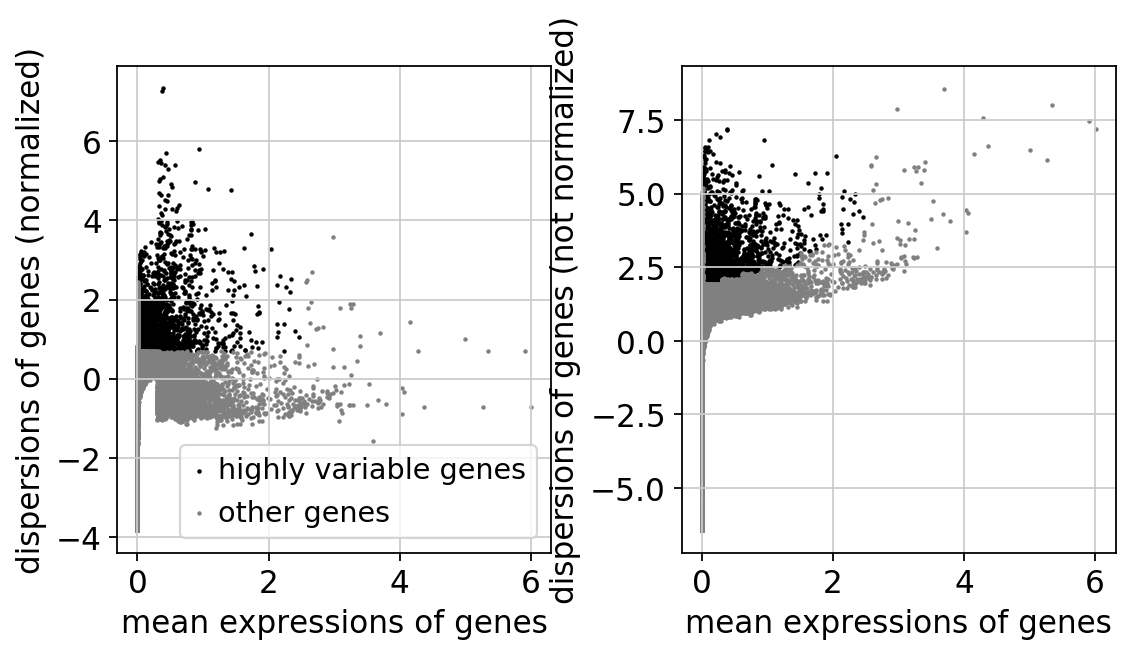

[2448, 24516]


In [55]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
sc.pl.filter_genes_dispersion(filter_result)
print([sum([i[0] for i in filter_result]),len(filter_result)])

Finish preprocessing the data by filtering it to the highly variable genes, log-transforming, scaling and performing PCA.

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


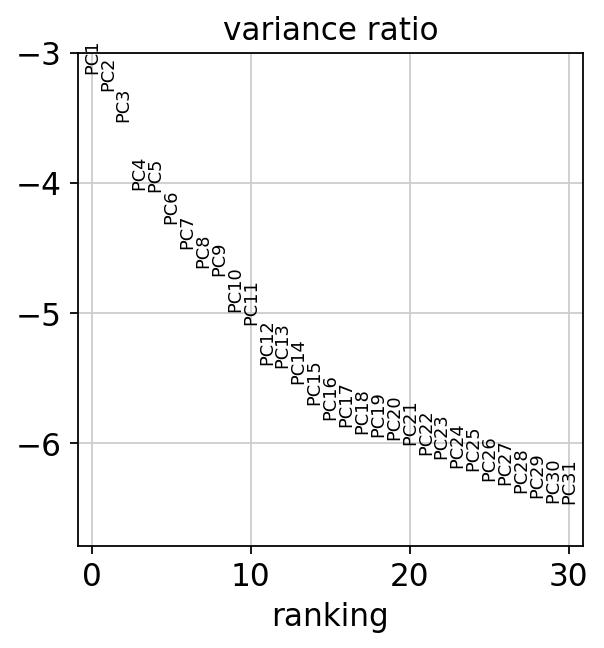

In [56]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata, log=True)

Use the elbow plot to propose a conservative 20 PC cutoff. Compute the standard neighbour graph and create the UMAP. While cells of similar type cluster together, the batch effect is glaring. Take note of the small butterfly-like cluster of macrophage and mast cells near the bottom, as it will be of relevance in one of the following plots and also comparisons to other methods. Also take note of the gamma and delta populations already merging with no batch effect correction in place.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:08.87) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:18.97) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)


... storing 'celltype' as categorical
... storing 'sample' as categorical


    finished (0:00:01.14) --> found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


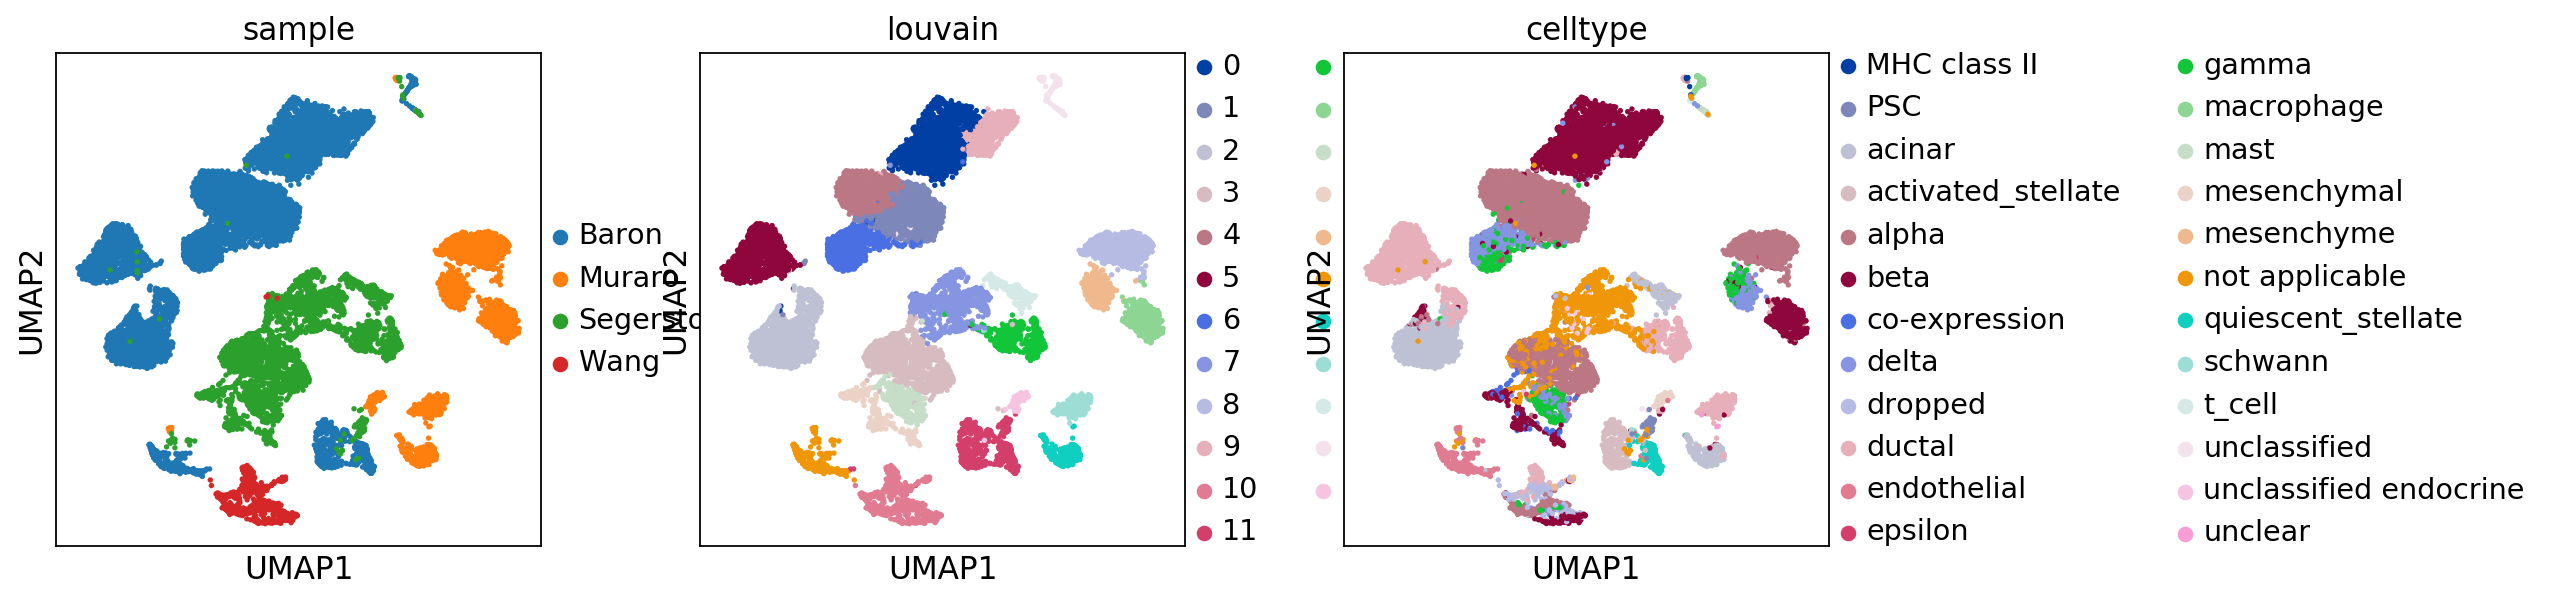

In [57]:
num_pcs = 20

sc.pp.neighbors(adata,n_pcs=num_pcs, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.louvain(adata)

sc.pl.umap(adata, color=['sample','louvain','celltype'])

#clear out the cluster plot colour map by hand, as otherwise it stays
del adata.uns['louvain_colors']

Replace regular neighbour inference with BBKNN, setting the `neighbors_within_batch` parameter to match our neighbour total for the previous step when multiplied by the number of batches. BBKNN uses `adata.obs['batch']` by default to split the batches, which is accurate in our case as each of our batches corresponds to one of the datasets. The `save_knn` and `copy` flags are merely used for subsequent visualisation, and can be skipped in most regular use.

The UMAP reveals the batches to be far better mixed than previously, while retaining cell type structure. It's the easiest to spot alpha (mauve) and beta (maroon) cells get joined together across the different datasets into cohesive entities, but this also applies to other cell types. The gamma and delta populations are still merged, consistent with them already exhibiting an affinity for each other in the previous correction-free visualisation.

computing batch balanced neighbors
    finished (0:00:07.26) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:16.53) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.88) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


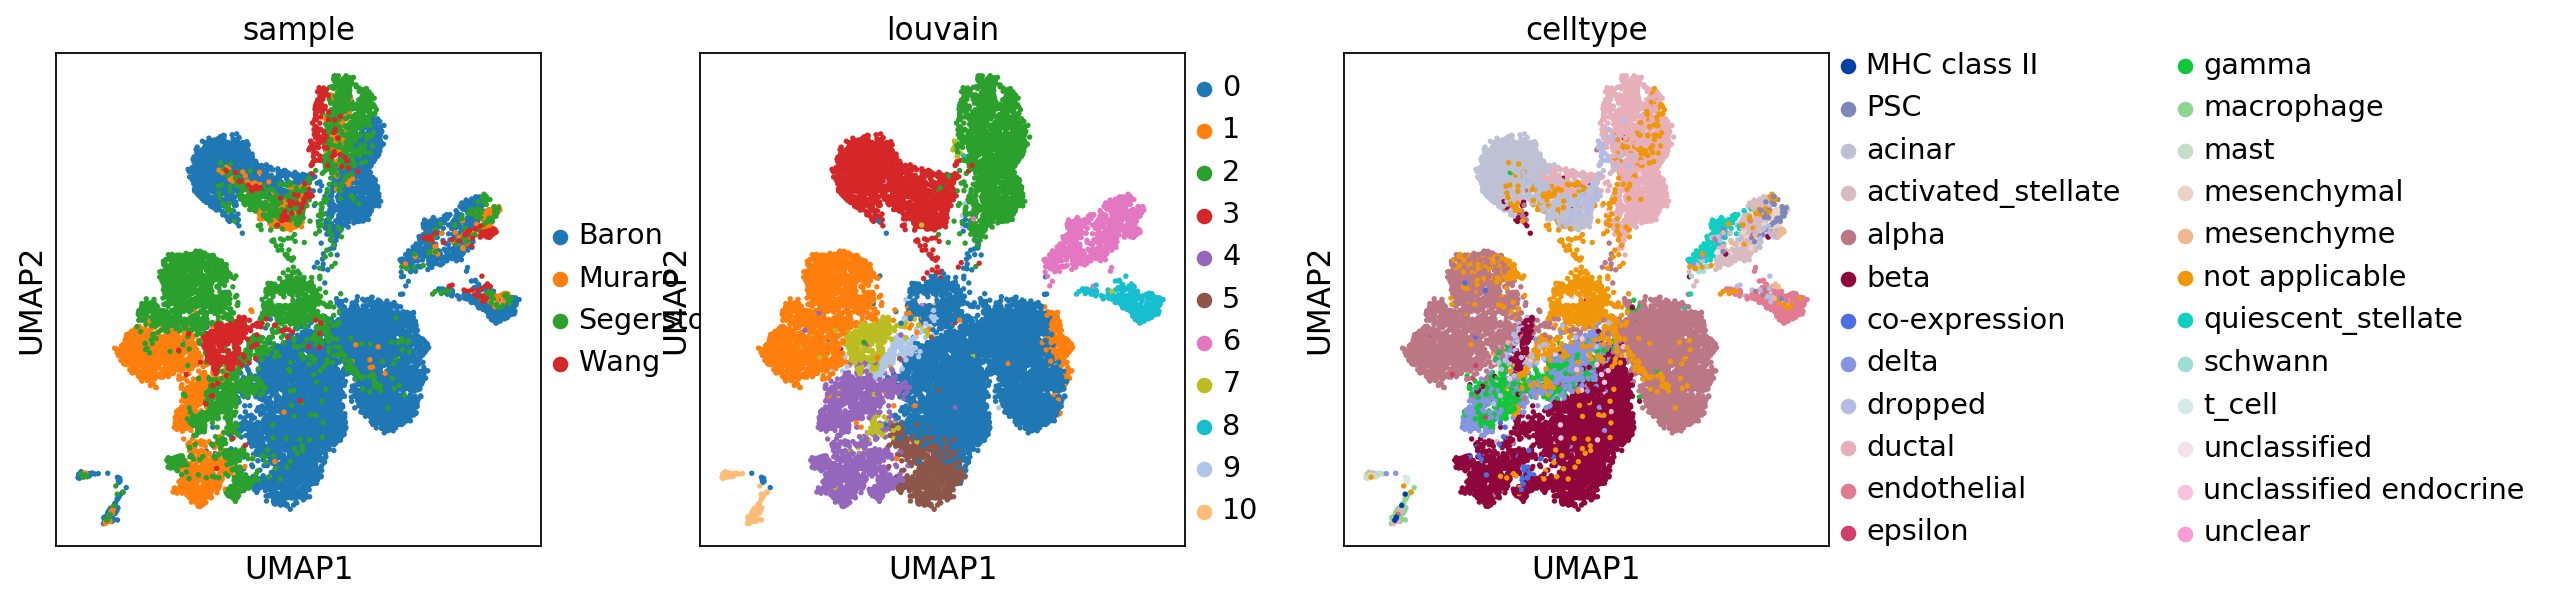

In [58]:
adata_bbknn = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, save_knn=True, copy=True)
sc.tl.umap(adata_bbknn)
sc.tl.louvain(adata_bbknn)

sc.pl.umap(adata_bbknn, color=['sample','louvain','celltype'])

While the cell types align quite well, the gamma/delta population sits on either side of the large alpha cluster and the clustering looks a little messy. The `trim` parameter can help with that, limiting the connectivities matrix to only feature a user-specified maximum number of highest rated connections for each cell. Let's add that, set to 50, and observe as the clustering gets tidier, aligning more to the biological ground truth cell types. The experiments also seem to integrate a little bit better than on the previous plot, and the gamma/deltas are no longer split by the alpha cluster. The macrophage/mast cell cluster is still independent.

computing batch balanced neighbors
    finished (0:00:05.86) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:14.84) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.82) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


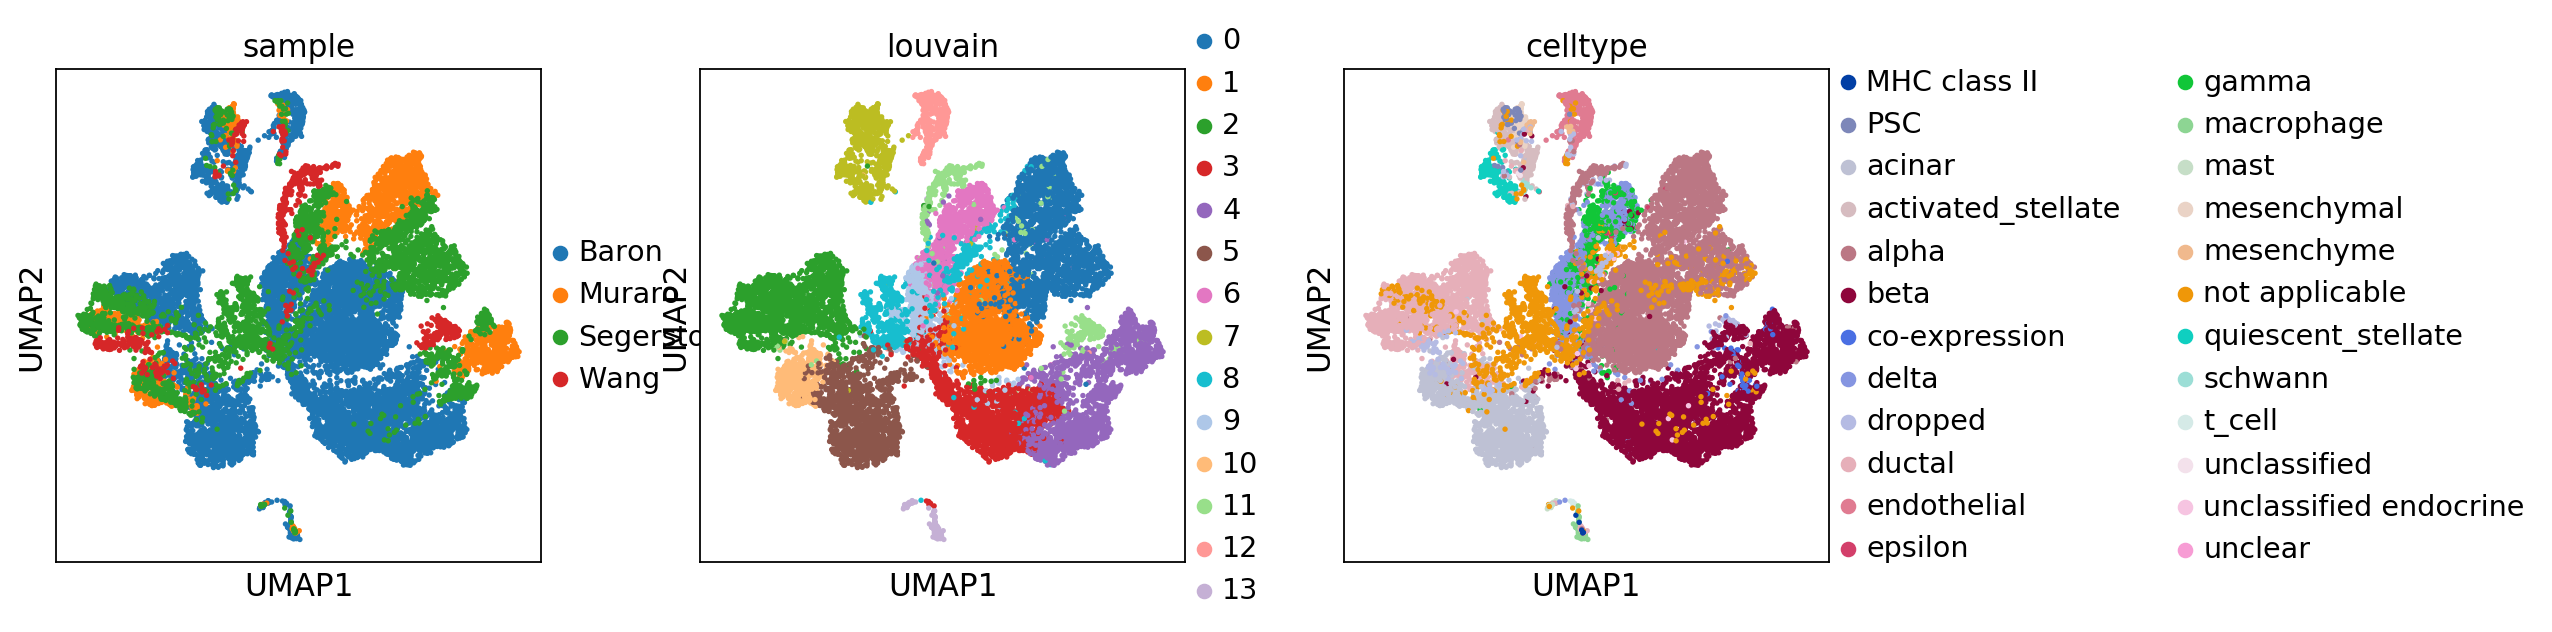

In [59]:
adata_bbknn_trim = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, trim=50, save_knn=True, copy=True)
sc.tl.umap(adata_bbknn_trim)
sc.tl.louvain(adata_bbknn_trim)

sc.pl.umap(adata_bbknn_trim, color=['sample','louvain','celltype'])

Since the datasets are quite different, `scale_distance` can be engaged to slightly improve the results. This subtly rewires the internal connectivity computation to place less emphasis on cells from the same batch. However, it also carries the risk of extending its delicate blending attempts to disparate cell groups.

Applying `scale_distance` to the data manages to showcase both the good and the bad: the datasets continue improving their merging, which can be noticed the easiest when comparing the placement of Wang sample cells. However, the butterfly-like macrophage/mast cell cluster is considerably closer to the bulk of the cells, and while it retains its cluster status it feels less independent in the visualisation.

computing batch balanced neighbors
    finished (0:00:07.64) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:13.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.75) --> found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


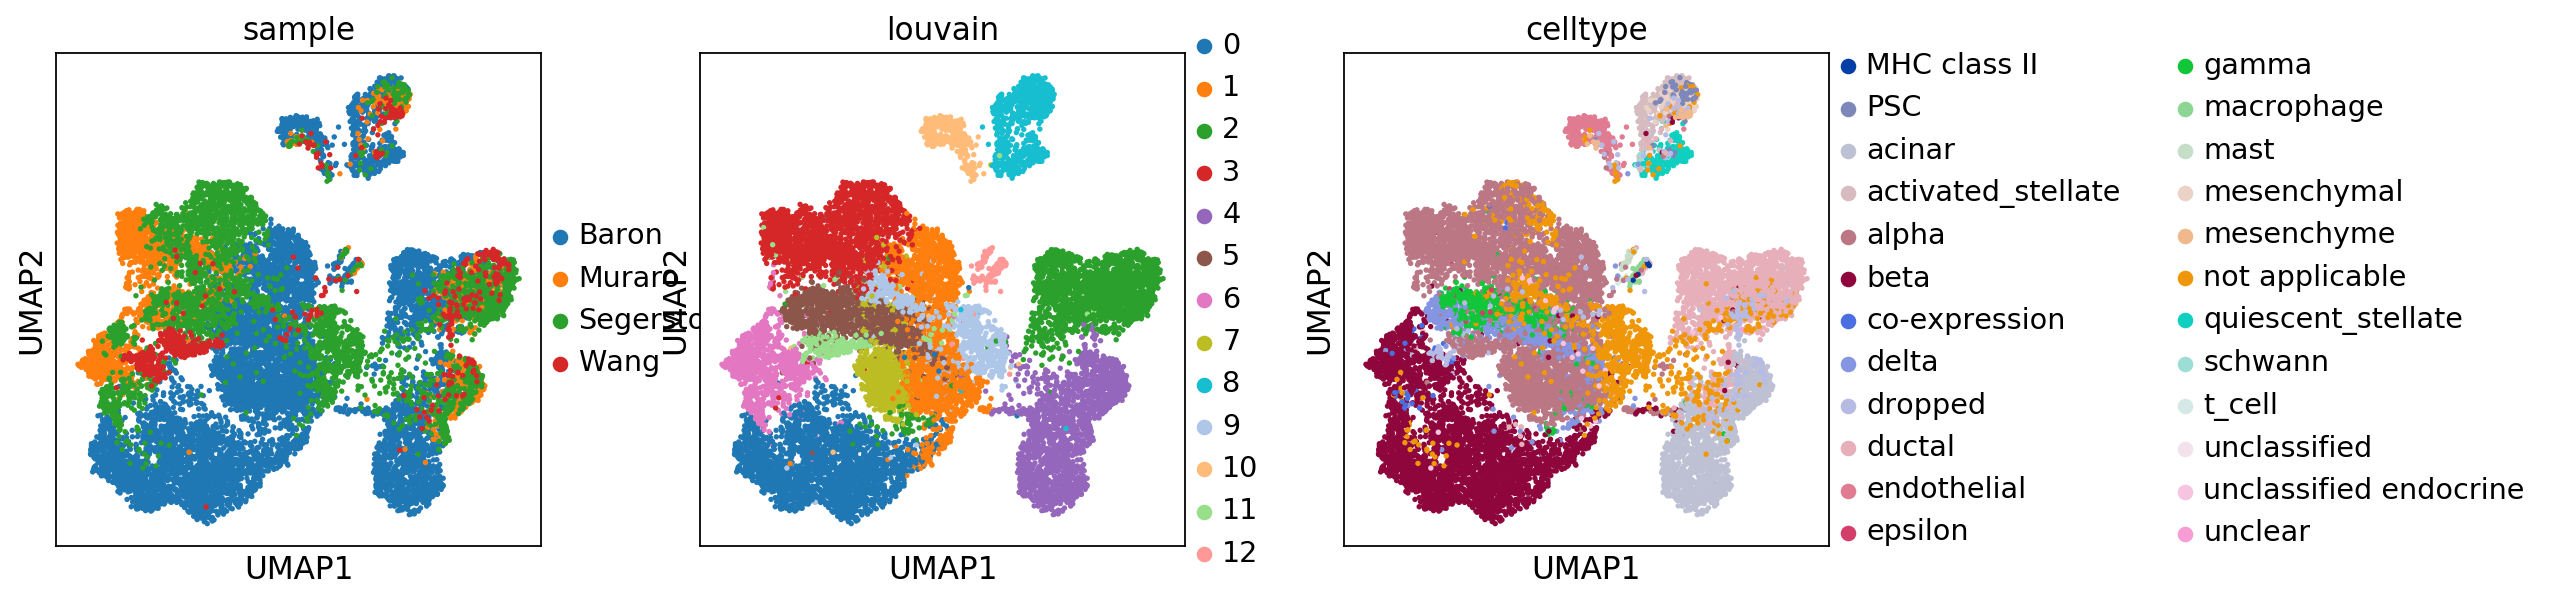

In [60]:
adata_bbknn_scale = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, trim=50,
                                scale_distance=True, save_knn=True, copy=True)
sc.tl.umap(adata_bbknn_scale)
sc.tl.louvain(adata_bbknn_scale)

sc.pl.umap(adata_bbknn_scale, color=['sample','louvain','celltype'])

By default, BBKNN computes its neighbours via `scipy.spatial.cDKTree`. While this algorithm offers good performance on datasets in the tens of thousands of cells, it scales worse as the size of the individual batches to merge goes up. As such, BBKNN also offers the option to identify approximate neighbours via annoy. Engaging this mode by providing `approx=True` in the argument list does not lead to a performance gain for the pancreatic data, but runs about 30 times faster when processing four batches of ~65,000 cells each. This is shown in the notebook `benchmark2.ipynb` in the GitHub repository.

It should be noted that the default metric of choice for the approximate neighbour algorithm is "angular" (cosine distance), while BBKNN's default setting of the metric argument is "euclidean". While the difference in output is subtle in most cases, keep this fact in mind when using the approximation.

In terms of output, approximate neighbour detection mostly falls in line with the previous visualisations. The macrophage/mast cluster appears marginally more independent than in the `scale_distance` output above. An interesting fact is that the gamma/delta populations seem the closest to separated here, possibly as the result of metric choice.

computing batch balanced neighbors
    finished (0:00:05.45) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:13.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.80) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


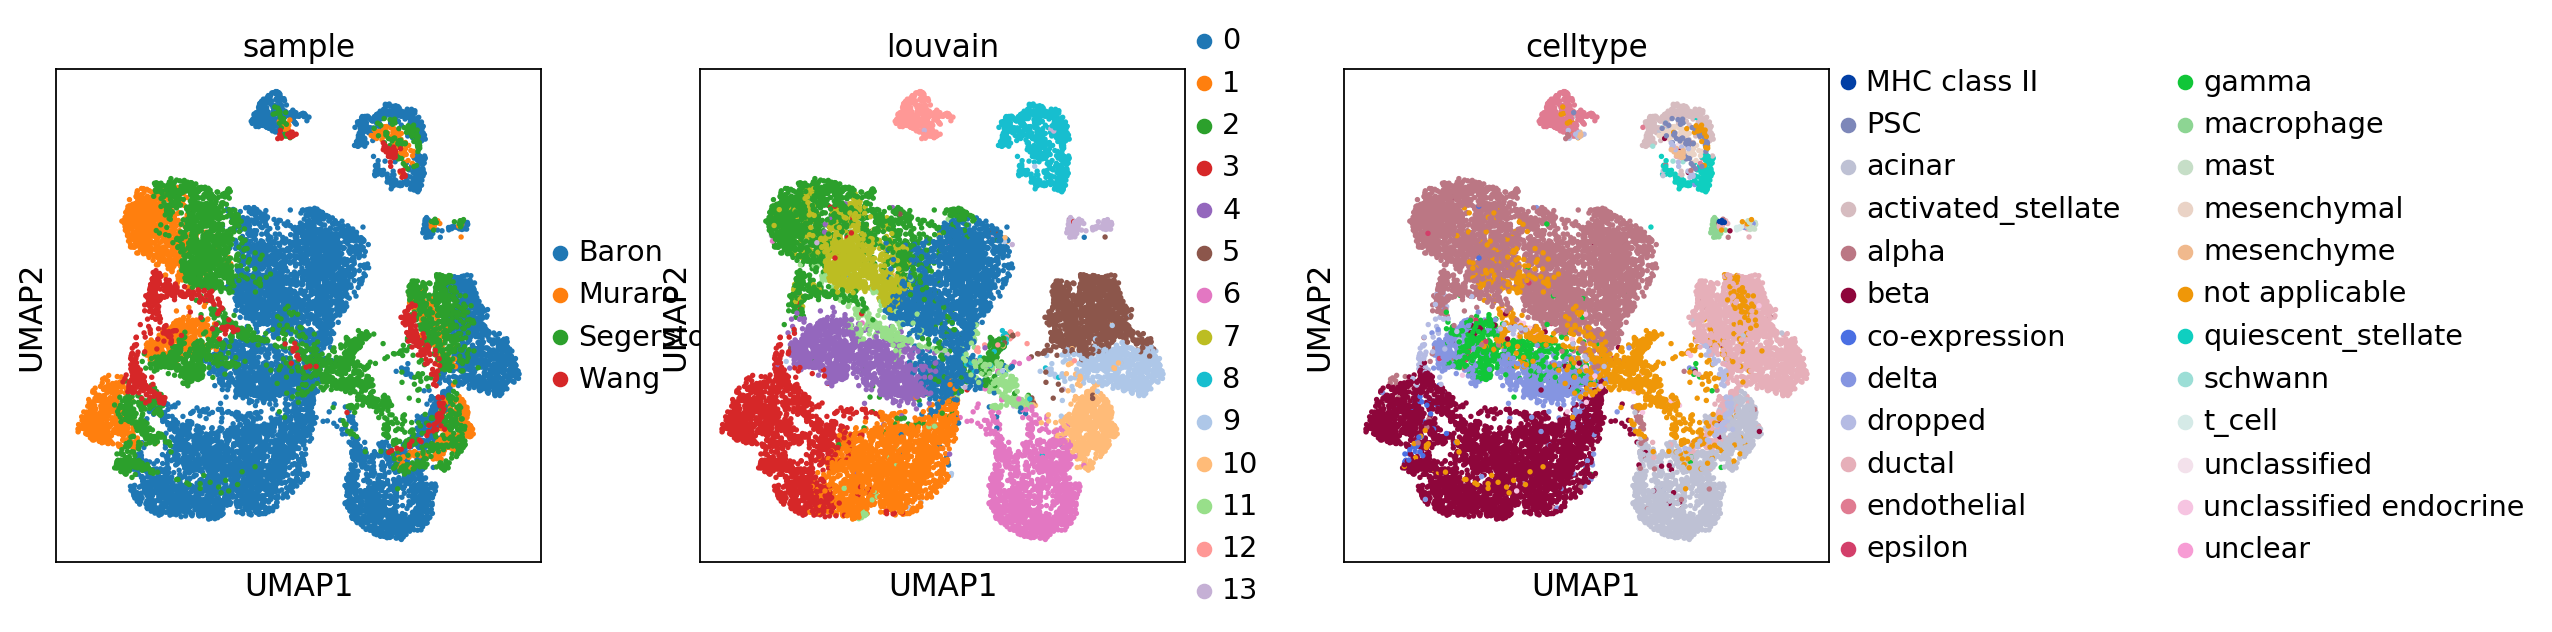

In [61]:
adata_bbknn_approx = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, trim=50,
                                 approx=True, metric='angular', save_knn=True, copy=True)
sc.tl.umap(adata_bbknn_approx)
sc.tl.louvain(adata_bbknn_approx)

sc.pl.umap(adata_bbknn_approx, color=['sample','louvain','celltype'])

Having explored all of the BBKNN options, let's take a closer look at the exact mechanics of what `scale_distance` does. This modification impacts the computation of the connectivities, which form an exponential relation with the original distance metric. The helper function below visualises the top neighbours' distances and connectivities, split per batch of origin.

In [62]:
import matplotlib.pyplot as plt

def DistConnPlot(adata, ind):
    plt.figure(figsize=(8,8))

    batches = adata.obs['batch'][adata.uns['bbknn'][ind,:]].tolist()
    batchkeys = np.unique(batches)
    batches[0] = '10'

    for j in batchkeys:
        plt.subplot(221+int(j))
        plt.plot(adata.uns['neighbors']['distances'][ind,adata.uns['bbknn'][ind,1:]].todense().tolist()[0], 
                 adata.uns['neighbors']['connectivities'][ind,adata.uns['bbknn'][ind,1:]].todense().tolist()[0], '--')
        mask = [True if item == j else False for item in batches]
        plt.scatter(adata.uns['neighbors']['distances'][ind,adata.uns['bbknn'][ind,mask]].todense().tolist()[0], 
                    adata.uns['neighbors']['connectivities'][ind,adata.uns['bbknn'][ind,mask]].todense().tolist()[0])

    plt.show()

Visualising this relationship for a cell from the Wang dataset reveals a few close neighbours within the same batch (bottom right subplot), with everything else being 20+ Euclidean distance away and assigned minuscule connectivities. The discrepancy is so glaring that the exponential distribution is more akin to three straight lines due to a lack of points in between the two extremes.

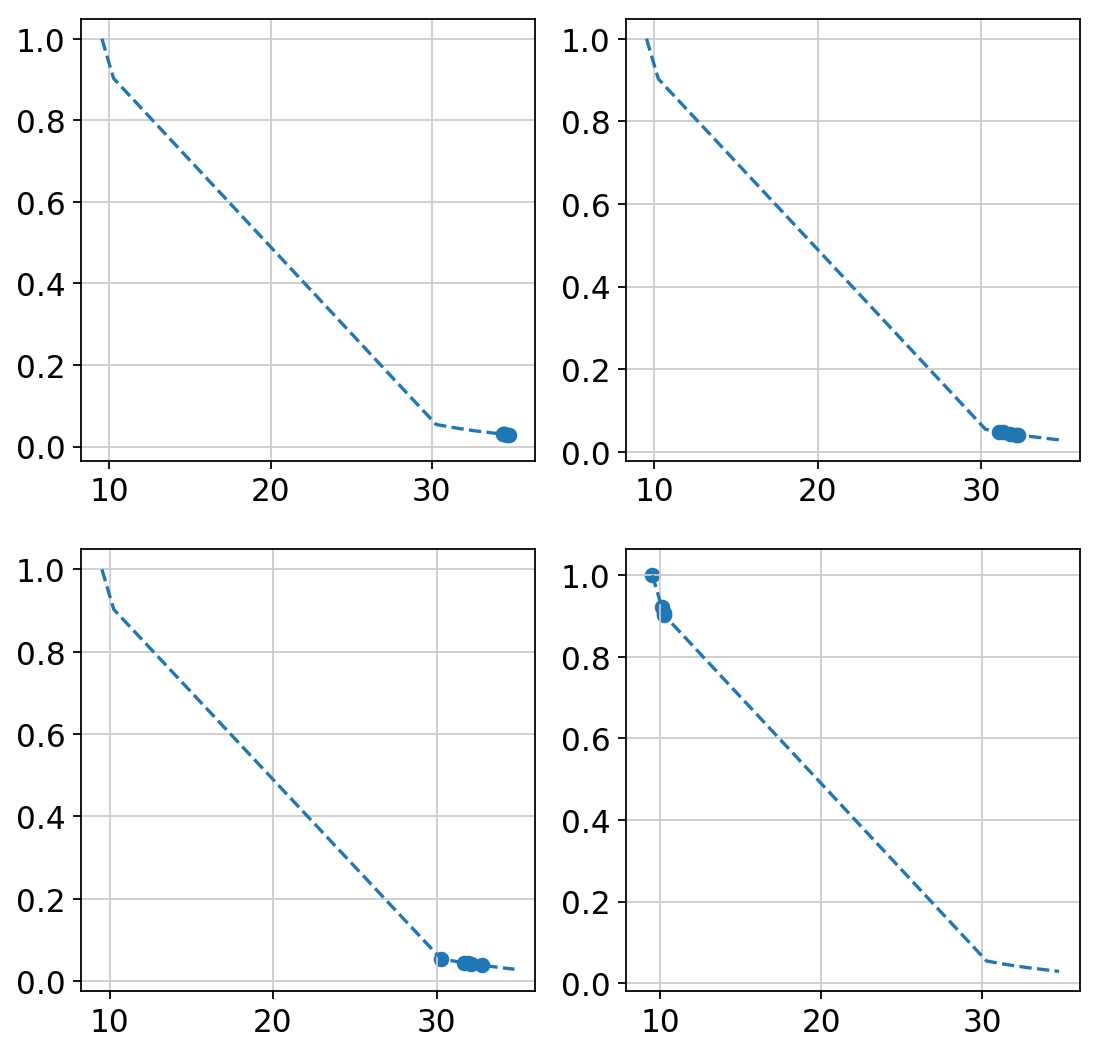

In [63]:
DistConnPlot(adata_bbknn, 14689)

`scale_distance` shifts the very distant batches to sit closer to the original batch, closing the distance gap and resulting in an alteration to the connectivities that places less emphasis on the neighbours from the original batch. The same cell's distance to connectivity is now more reminiscent of the underlying exponential distribution relation. BBKNN is ran prior to the visualisation with trimming disabled to recapture a set of trimming-induced dropouts and place more points on the curve (seeing how the curve is the focus here). Running the plotting for different cells may result in upwards spikes being present in the distribution. The distance to connectivity computation is performed independently for each cell's neighbours, with mutual neighbour pairs subsequently being set to the higher of the two computed connectivities.

computing batch balanced neighbors
    finished (0:00:07.85) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


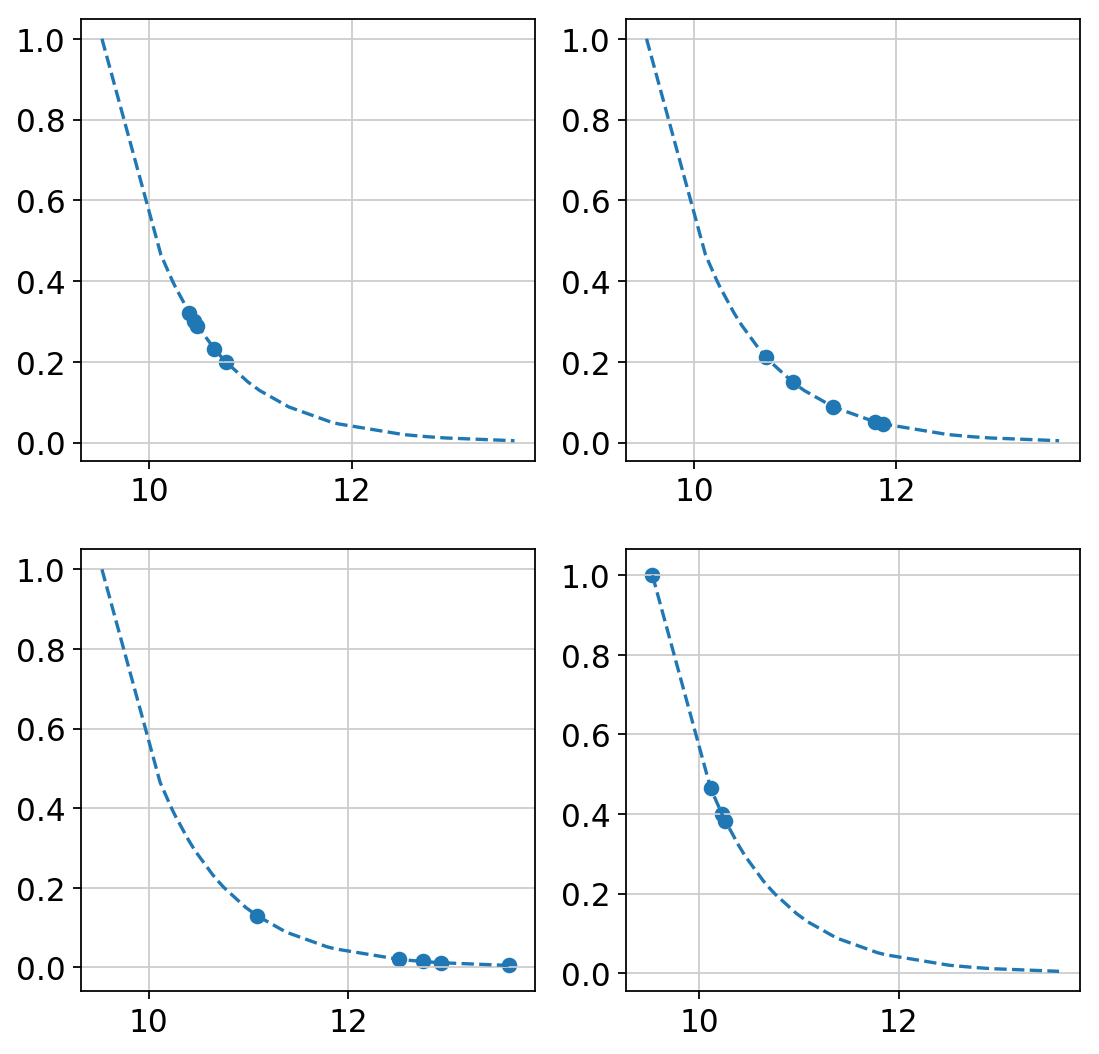

In [64]:
adata_bbknn_scale_notrim = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, 
                                       scale_distance=True, save_knn=True, copy=True)

DistConnPlot(adata_bbknn_scale_notrim, 14689)

Write out the objects for potential later use. All of them can be downloaded as a zipped up bundle from [ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip)

In [65]:
if not os.path.exists('bbknn-pancreas'):
    os.makedirs('bbknn-pancreas')

adata.write('bbknn-pancreas/pancreas.h5ad')
adata_bbknn.write('bbknn-pancreas/pancreas_bbknn.h5ad')
adata_bbknn_trim.write('bbknn-pancreas/pancreas_bbknn_trim.h5ad')
adata_bbknn_scale.write('bbknn-pancreas/pancreas_bbknn_scale.h5ad')
adata_bbknn_approx.write('bbknn-pancreas/pancreas_bbknn_approx.h5ad')